In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Download SO training set
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, cache_dir='data/', cache_subdir='')

6053888/6053168 [==============================] - 1s 0us/step


In [2]:
train_dir = os.path.join(os.path.dirname(dataset), 'train')
test_dir = os.path.join(os.path.dirname(dataset), 'test')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [3]:
sample = os.path.join(train_dir, 'python/100.txt')
with open(sample) as f:
    print(f.read())

"blank syntax doubt hey, i have been using the pymt library and they have this convention to referring their widgets:..from pymt import *..# create a slider from 0.-1..sl = mtxyslider()..@sl.event.def on_value_change(x, y):.    print 'slider value change', x, y..runtouchapp(sl)...what's with the ""@""? what does it signify in blank?thanks."



# Preprocessing

In [4]:
# Split train into train and val
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(test_dir, batch_size=batch_size) 

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [7]:
print(raw_train_ds.class_names)
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])
        print()

['csharp', 'java', 'javascript', 'python']
b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. 

In [8]:
# Text Vectorisation Layer
max_features = 5000
embedding_dim = 128
sequence_length = 500

vectorise_layer = TextVectorization(
    max_tokens=max_features, 
    output_mode='int', 
    output_sequence_length=sequence_length
)

# Train vectorisation - GENERATES THE VOCABULARY
train_text = raw_train_ds.map(lambda x, y: x)
vectorise_layer.adapt(train_text)

# Test Vectorisation
def vect_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorise_layer(text), label

# Vectorise data
train_ds = raw_train_ds.map(vect_text)
val_ds = raw_val_ds.map(vect_text)
test_ds = raw_test_ds.map(vect_text)

In [9]:
# Configure for performance (chaching and preprocessing)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Build the model
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim), # Creates a vector that represents the input in a continuous vector space
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(), # Converts to a fixed length output vector, to generalise to different length texts
    layers.Dropout(0.2),
    layers.Dense(4) # Densely connects the intermediate layers to a 4 output nodes, as we have 4 classes
])

model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         640128    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 640,644
Trainable params: 640,644
Non-trainable params: 0
_________________________________________________________________


In [11]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
200/200 [==============================] - 17s 87ms/step - loss: 1.3733 - accuracy: 0.3338 - val_loss: 1.3564 - val_accuracy: 0.4269
Epoch 2/10
200/200 [==============================] - 5s 23ms/step - loss: 1.3240 - accuracy: 0.4581 - val_loss: 1.2885 - val_accuracy: 0.5175
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 1.2313 - accuracy: 0.5720 - val_loss: 1.1780 - val_accuracy: 0.6562
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 1.1160 - accuracy: 0.6356 - val_loss: 1.0626 - val_accuracy: 0.7025
Epoch 5/10
200/200 [==============================] - 6s 30ms/step - loss: 1.0044 - accuracy: 0.6881 - val_loss: 0.9602 - val_accuracy: 0.7306
Epoch 6/10
200/200 [==============================] - 6s 30ms/step - loss: 0.9065 - accuracy: 0.7236 - val_loss: 0.8757 - val_accuracy: 0.7462
Epoch 7/10
200/200 [==============================] - 7s 33ms/step - loss: 0.8251 - accuracy: 0.7508 - val_loss: 0.8073 - val_accuracy: 0.759

In [15]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 56s 223ms/step - loss: 0.7149 - accuracy: 0.7515
Loss:  0.7148568630218506
Accuracy:  0.7515000104904175


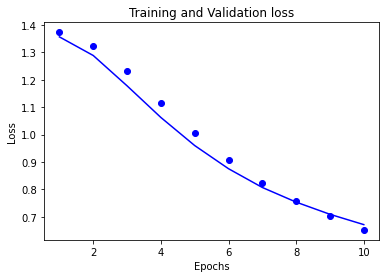

In [13]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

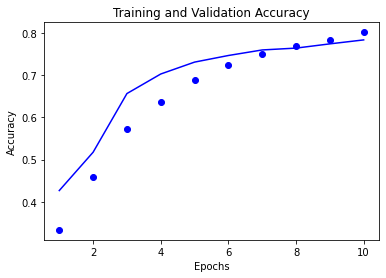

In [14]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We can see that the loss and accuracy for the validation and training set follow a similar trend ond dont deviate, indicating that we have avoided overfitting